In [1]:
import numpy as np
from matplotlib import pyplot as plt
import glob

# Define functions

In [18]:
g = 9.81 # m/s2, gravity
beta = 1e-4 # degC-1, thermal coefficient expansion water
deltaT = 20.5 # degC, melting-ambient
alpha = 0.133e-6 # m2/s, thermal diffiusivity water
#alpha = 1.02e-6 # m2/s, thermal diffiusivity ice
nu = 1.4e-6 # m2/s, kinematic viscosity water
Pr = 10 # variable
kappa = 580e-3 # W/Km, thermal conductivity water
T_in = 16 # degC, initial negative temperature ice
rho_ice = 917 # kg/m3, density ice
L_f = 334e3 # J/kg, latent heat fusion water
c_s = 4186 # J/kgK, specific heat water 

def Nu_areas(A,T_water, dt):
    """Returns an approximated value of the Nusselt number that accounts for the latent and sensitive heat.
    The parameter passed is the area of the cylinder. 

    Args:
        A (float): area of cylinder [m2]
        T_water (float): bulk water temperature [degC]
        dt (float): time interval [s]

    Returns:
        float: value of Nusselt number
    """   
    h = -(np.gradient(A)/dt)*rho_ice*(L_f+c_s*T_in)/(np.pi*T_water)
    return h/kappa

def PolyArea(x,y):
    """Returns area of a polygon given the x,y-coordinates of its points

    Args:
        x (np.array): x-coordinates
        y (np.array): y-coordinates

    Returns:
        _type_: _description_
    """    
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def correct_outliers(y,precision=0.1):
    """Corrects outliers by interpolating between them. Outliers are defined where there is a change of more than a certain fraction in the normalised gradient. 
    This function can only handle one outlier.

    Args:
        y (np.array): input array
        precision (float) : between 0 and 1, max allowed change in the gradient

    Returns:
        np.array: array without outliers.
    """    
    outliers = np.where(abs(np.gradient(y/y[0]))>precision)[0]
    if len(outliers)>1:
        # only works if there is one outlier
        y[np.mean(outliers,dtype=int)] = np.nan
        y = np.array(y)
        nans,x = nan_helper(y)
        y[nans] = np.interp(x(nans),x(~nans),y[~nans])
    return y

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.
    https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def polynomial_fitting(xdata,ydata,degree,boolPlot):
    """Fits a polynomial to data. 

    Args:
        xdata (np.array/list): data that will be on x axis
        ydata (np.array/list): data to be fitted (on y axis)
        degree (int): degree of polynomial
        boolPlot (bool): wheter to plot a line with the output or not
    Returns:
        np.array: parameters of best fitting function
        np.poly1d: polynomial element of numpy
    """    
    fit_par = np.polyfit(xdata, ydata,degree)
    yfit = np.poly1d(fit_par)
    if boolPlot: plt.plot(xdata, yfit(xdata),c='k',linestyle='--')
    return fit_par,yfit

def running_mean(x,N):
    """Function that returns the running mean on the array x with window N

    Args:
        x (np.array): input array
        N (int): window size

    Returns:
        np.array: averaged array (len = len(x)-N+1)
    """    
    return np.convolve(x, np.ones(N)/N, mode='valid')

def sigmoid_fitting(xdata,ydata,exp_y0,boolPlot):
    """Fits a sigmoid function (sigmoid) to data. 

    Args:
        xdata (np.array/list): data that will be on x axis
        ydata (np.array/list): data to be fitted (on y axis)
        exp_y0 (float): known (experimental) value for the ydata[0]
        boolPlot (bool): wheter to plot a line with the output or not
    Returns:
        np.array: best fitting function
    """    
    p0 = [-ydata[0], xdata[-1]/2,exp_y0*1e2/xdata[-1],ydata[0]] 
    popt, _ = curve_fit(sigmoid, xdata, ydata,p0,maxfev=int(1e5))
    if boolPlot: plt.plot(xdata, sigmoid(xdata,popt[0],popt[1],popt[2],popt[3]),c='k',linestyle='--')
    return sigmoid(xdata,popt[0],popt[1],popt[2],popt[3])

def sigmoid(x, L ,x0, k, b):
    """Returns a sigmoid function 

    Args:
        x (np.array): input array
        L (float): function parameter
        x0 (float): function parameter
        k (float): function parameter
        b (float): function parameter

    Returns:
        np.array: output array
    """    
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

# Radius vs time

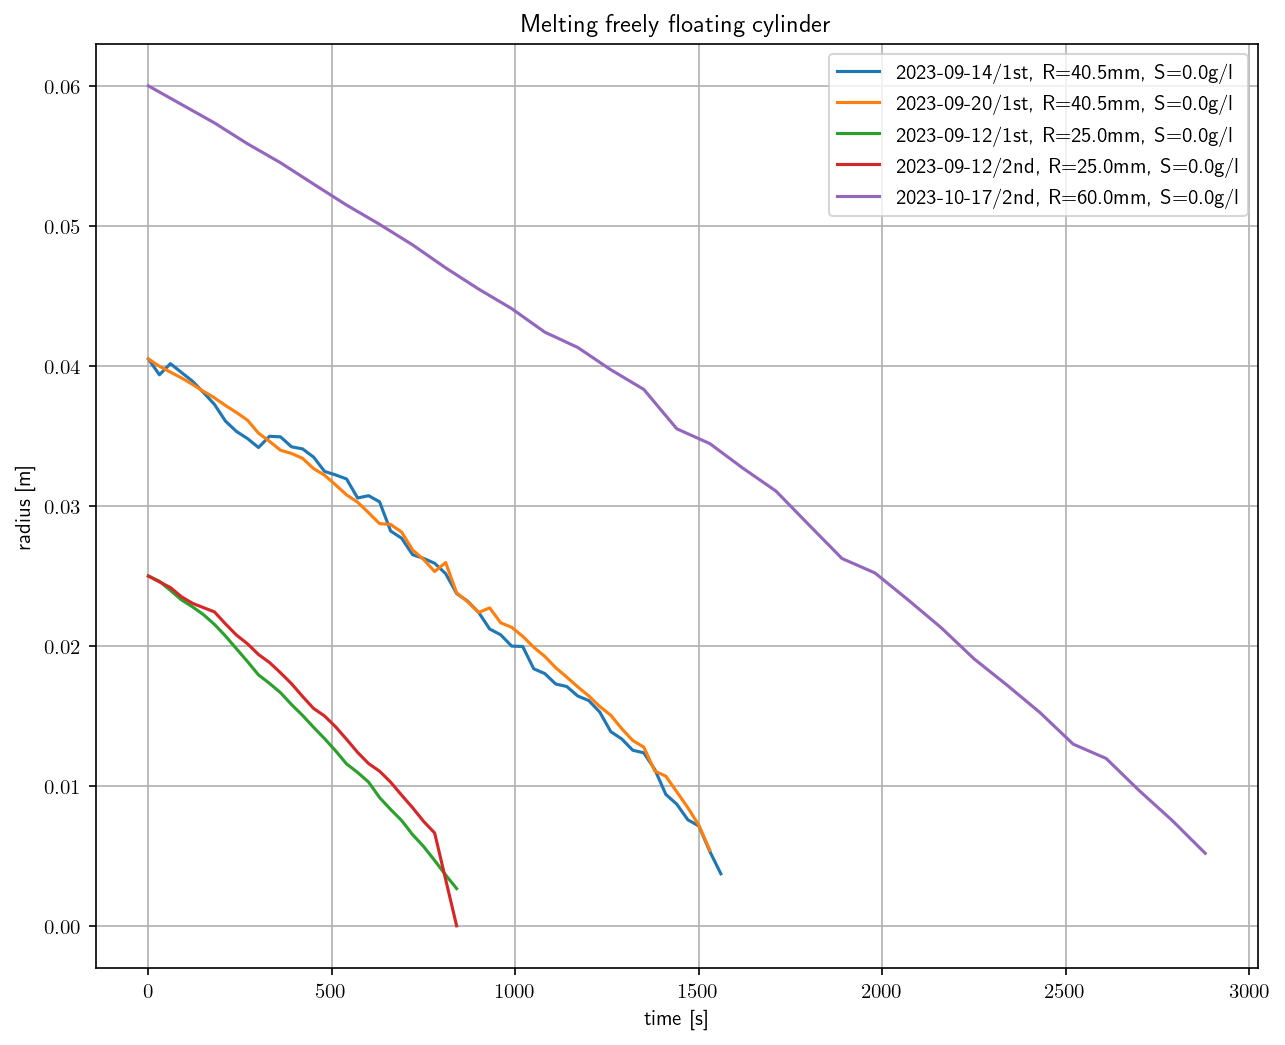

In [11]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/codes/floatingIce/data_zeroSalt/'

cylinders = ['2023-09-14/1st','2023-09-20/1st', '2023-09-12/1st','2023-09-12/2nd', '2023-10-17/2nd',# S=0
             ]

plt.figure(figsize=(10,8),dpi=150)
plt.rcParams['text.usetex'] = True

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    if exp_radius == 0.06: 
        interval = 30
    else:
        interval = 10

    radii = []
    for it, contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: 
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)/conversion
        radii.append(radius)
    
    radii = correct_outliers(radii)

    plt.plot(contours_per_shot*interval*np.arange(len(radii)),radii,
            label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') # one shot every 30 seconds

plt.grid()
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('radius [m]')
plt.title('Melting freely floating cylinder')
plt.show()

## Fitting stuff to radii

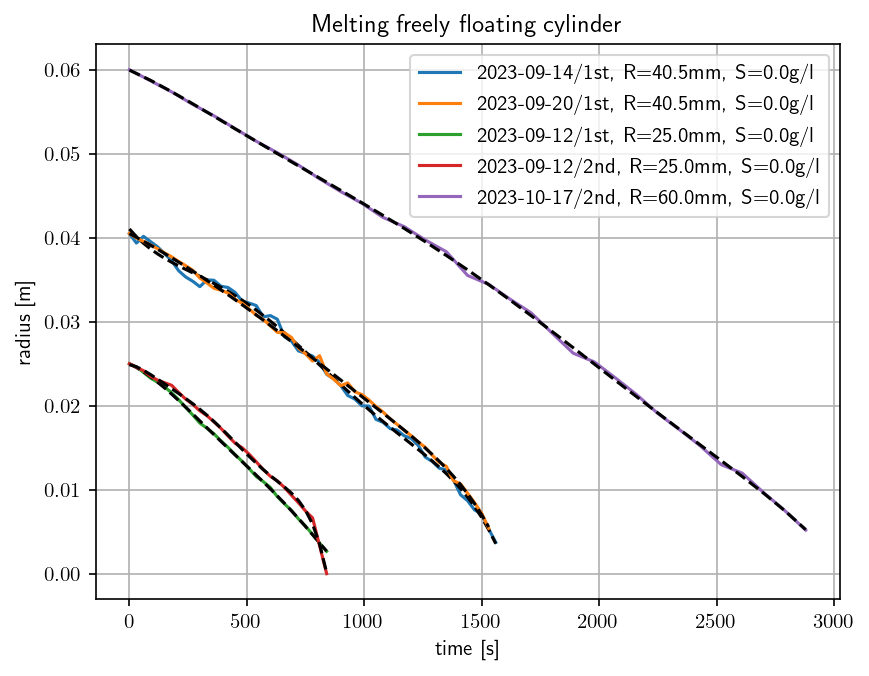

In [14]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/codes/floatingIce/data_zeroSalt/'

cylinders = ['2023-09-14/1st','2023-09-20/1st', '2023-09-12/1st','2023-09-12/2nd', '2023-10-17/2nd',# S=0
             ]

plt.figure(dpi=150)
plt.rcParams['text.usetex'] = True

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    if exp_radius == 0.06: 
        interval = 30
    else:
        interval = 10

    radii = []
    for it, contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: 
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)/conversion
        radii.append(radius)
    
    radii = correct_outliers(radii)

    plt.plot(contours_per_shot*interval*np.arange(len(radii)),radii,
                label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') # one shot every 30 seconds
    
    # _ = sigmoid_fitting(contours_per_shot*interval*np.arange(len(radii)),radii,exp_y0=exp_radius,boolPlot=1)
    _, _ = polynomial_fitting(contours_per_shot*interval*np.arange(len(radii)),radii,degree=6,boolPlot=1)

plt.grid()
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('radius [m]')
plt.title('Melting freely floating cylinder')
plt.show()

# Nusselt vs time

Data is now fitted with a 6th order polynomial. Averaged vectors are stored in a 2D-dictionary called "averages" where the first dimension is salinity (0.0 only in your case), and the second dimension is the radius. So if you call averages[0.0][0.0405] you get the nusselt numbers of the corresponding experiments, averaged in time between the two experiments. 

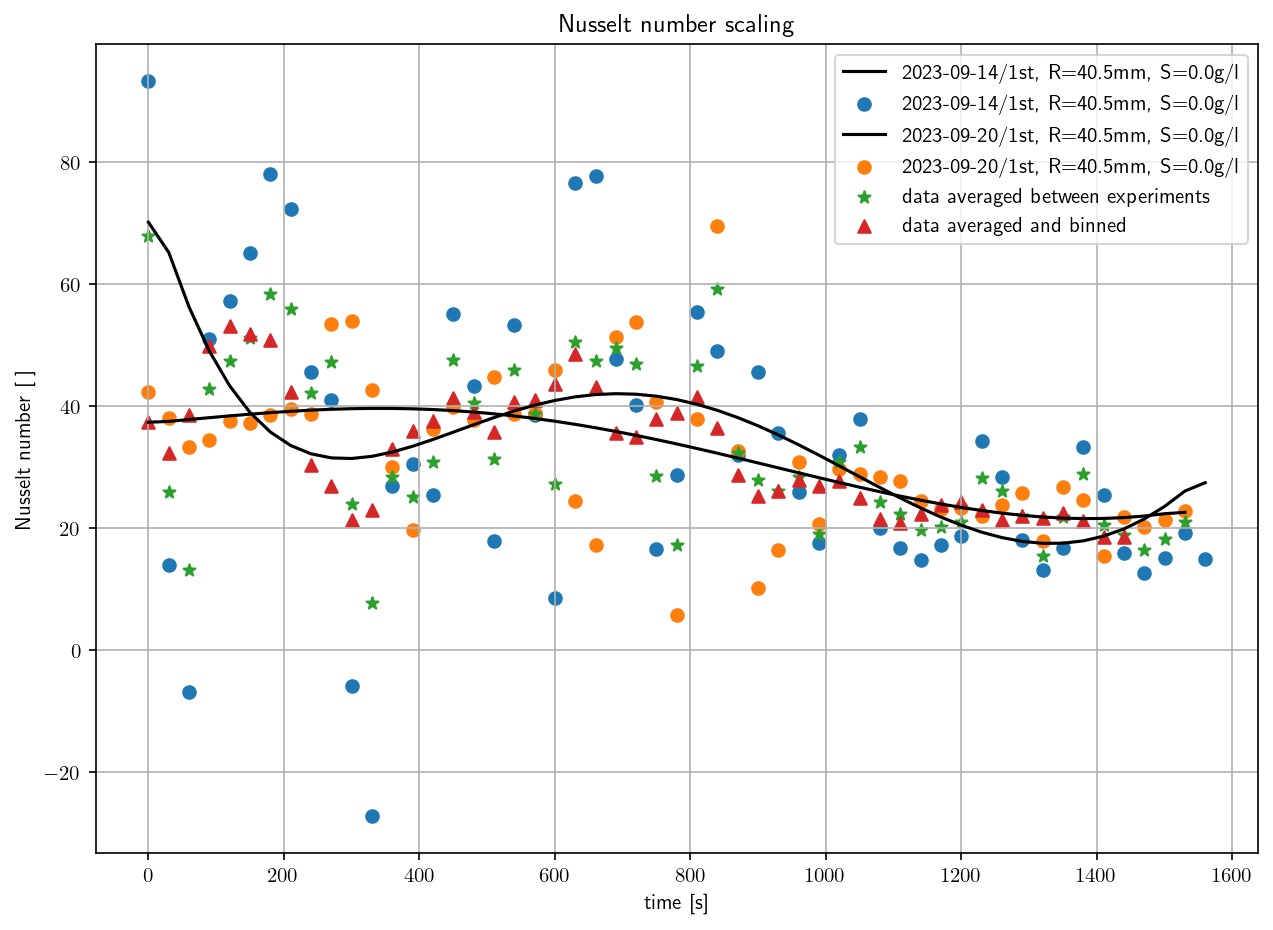

In [21]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/codes/floatingIce/data_zeroSalt/'

cylinders = ['2023-09-14/1st','2023-09-20/1st', '2023-09-12/1st','2023-09-12/2nd', '2023-10-17/2nd',# S=0
             ]
# dictionary
averages = {
    '0.0': {
        '0.025': [np.nan],
        '0.0405': [np.nan],
        '0.06': [np.nan]
    },
    '10.0': {
        '0.025': [np.nan],
        '0.0405': [np.nan],
        '0.06': [np.nan]
    },
    '35.0': {
        '0.025': [np.nan],
        '0.0405': [np.nan],
        '0.06': [np.nan]
    }
}

plt.figure(figsize=(10,7),dpi=150)
plt.rcParams['text.usetex'] = True

for ic,cylinder in enumerate(cylinders):
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    if exp_radius == 0.06: 
        interval = 30
    else:
        interval = 10

    if exp_radius != 0.0405: continue

    areas = []
    for it,contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: 
            initialArea = np.pi*exp_radius**2 # m2
            conversion = PolyArea(contour[:,1],contour[:,0])/initialArea # px/m2
        area = PolyArea(contour[:,1],contour[:,0]) #px
        areas.append(area)
    
    areas = correct_outliers(areas)

    areas = np.array(areas)
    areas /= conversion

    # areas_fit =sigmoid_fitting(contours_per_shot*interval*np.arange(len(areas)),areas,exp_y0=initialArea,boolPlot=0)
    _,areas_fit = polynomial_fitting(contours_per_shot*interval*np.arange(len(areas)),areas,degree=6,boolPlot=0)
    areas_fit = areas_fit(contours_per_shot*interval*np.arange(len(areas)))
    
    Nusselt_numbers = Nu_areas(areas_fit,exp_wt,interval*contours_per_shot)
    plt.plot(contours_per_shot*interval*np.arange(len(areas)),Nusselt_numbers,
                label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l',c='k') 

    Nusselt_numbers = Nu_areas(areas,exp_wt,interval*contours_per_shot)
    plt.scatter(contours_per_shot*interval*np.arange(len(areas)),Nusselt_numbers,
                label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') 
    
    if len(averages[str(exp_sal)][str(exp_radius)])<2 :
        averages[str(exp_sal)][str(exp_radius)] = Nusselt_numbers
    else:
        diffInLen = len(Nusselt_numbers)-len(averages[str(exp_sal)][str(exp_radius)])
        if diffInLen>0:
            averages[str(exp_sal)][str(exp_radius)]= np.pad(averages[str(exp_sal)][str(exp_radius)],(0,diffInLen),'constant',constant_values=np.nan)
        else:
            Nusselt_numbers= np.pad(Nusselt_numbers,(0,abs(diffInLen)),'constant',constant_values=np.nan)
        averages[str(exp_sal)][str(exp_radius)] = np.mean((Nusselt_numbers,averages[str(exp_sal)][str(exp_radius)]),axis=0)

for exp_sal in [0.0,10.0,35.0]:
    for exp_radius in [0.025,0.0405,0.06]:
        if len(averages[str(exp_sal)][str(exp_radius)])>2:
            plt.scatter(3*10*np.arange(len(averages[str(exp_sal)][str(exp_radius)])),averages[str(exp_sal)][str(exp_radius)],
                marker='*',label='data averaged between experiments') 
            window=4
            plt.scatter(3*10*np.arange(len(averages[str(exp_sal)][str(exp_radius)])+1-window),running_mean(averages[str(exp_sal)][str(exp_radius)],window),
                marker='^',label='data averaged and binned') 
    
plt.grid()
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('Nusselt number [ ]')
plt.title('Nusselt number scaling')

plt.show()
